In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import svm, feature_selection, linear_model
from sklearn.model_selection import train_test_split


In [263]:
def markOutliers(df,columns):

    t = np.zeros(df.shape[0])
    z = np.zeros(df.shape[0])
    for column in columns:
        mean=np.mean(df[column])
        sd=np.std(df[column])
        threshold=2
        test=[]

        for i, x in enumerate(df[column]):
            if column=="SALE_PRICE":
                if x<10000:
                    t[i]=1
            z[i]=(x-mean)/sd
            if z[i]>=threshold:
                test.append((x,z[i]))
                t[i]=1
        print(column,'\n', test)
    df['outlier']=t
    
    return df

In [264]:
def fillNeighborhood(df):
    zip_to_neigh={}
    for i,r in df.iterrows():
        if  not pd.isnull(r["NEIGHBORHOOD"]) and not pd.isnull(r["ZIP_CODE"]):
            zip_to_neigh[r["ZIP_CODE"]] = r["NEIGHBORHOOD"]
    for i,r in df.iterrows():
        if  pd.isnull(r["NEIGHBORHOOD"]) and not pd.isnull(r["ZIP_CODE"]):
            r["NEIGHBORHOOD"]=zip_to_neigh[r["ZIP_CODE"]]
    return df

In [265]:
def checkUnits(df):
    t = np.zeros(df.shape[0])
    for i, r in df.iterrows():
        if pd.isnull(r["RESIDENTIAL_UNITS"]) and pd.isnull(r["COMMERCIAL_UNITS"]) and pd.isnull(r["TOTAL_UNITS"]):
            t[i]=1
    df['no_units']=t
    return df

def fillUnits(df):
    df[["RESIDENTIAL_UNITS", "COMMERCIAL_UNITS", "TOTAL_UNITS"]]=df[["RESIDENTIAL_UNITS", "COMMERCIAL_UNITS", "TOTAL_UNITS"]].replace(np.NaN, 0)
    count=0
    for i, r in df.iterrows():
        if r["RESIDENTIAL_UNITS"]+r["COMMERCIAL_UNITS"]!=r["TOTAL_UNITS"]:
            r["TOTAL_UNITS"]=r["RESIDENTIAL_UNITS"]+r["COMMERCIAL_UNITS"]
            print(r["TOTAL_UNITS"],r["RESIDENTIAL_UNITS"],r["COMMERCIAL_UNITS"])
    return df["TOTAL_UNITS"]



In [266]:
def step2_clean_1():
    df = pd.read_csv("Manhattan12.csv")

    # Print shape
    print(df.shape)

    # Rename incorrect column names
    df.rename(columns={"APART\r\nMENT\r\nNUMBER":"APARTMENT NUMBER", "SALE\r\nPRICE":"SALE PRICE"}, inplace = True)
    numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE']
    categorical=['BOROUGH','NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT','EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'
    ]
    df.columns=df.columns.str.replace(' ', '_')
    # df_num_man=df.filter(['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE']).copy()

    #num_cols=pd.concat([num_cols,df_num_man], axis=1, join='inner')
    df[numerical]=df[numerical].replace('\$','', regex=True)
    df[numerical]=df[numerical].replace(',','', regex=True)


    df['SALE_DATE']=pd.to_datetime(df['SALE_DATE'], dayfirst=True)
    df[categorical]=df[categorical].replace(' ', '', regex=True)
    df[categorical]=df[categorical].replace('', np.NaN)

    df[numerical]=df[numerical].apply(pd.to_numeric)
    df[numerical]=df[numerical].replace(0, np.NaN)
    df.drop_duplicates(inplace=True)
    df.dropna(subset=["NEIGHBORHOOD"], inplace=True)

    df["TOTAL_UNITS"]=fillUnits(df)
    df=checkUnits(df)
    df=df[df.no_units==0]
    df=df.drop('no_units', axis=1)
    df.reset_index(drop=True, inplace=True)

    df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT_NUMBER'], inplace=True)
    df=markOutliers(df, numerical)
    df=df[df.outlier==0]
    df=df.drop('outlier', axis=1)
    df.reset_index(drop=True, inplace=True)

    df[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET", "SALE_PRICE"]].interpolate()

    return df

In [267]:
def convertNeighborhood(df):
    m = np.zeros(df.shape[0])
    dfgroup=df.groupby(by="NEIGHBORHOOD", as_index=False).mean()
    #df.groupby(by="NEIGHBORHOOD", as_index=False).mean().to_csv('groupednorm.csv')
    print(dfgroup)
    
    n=np.zeros(dfgroup.shape[0])
    for i, r in dfgroup.iterrows():
        if r["SALE_PRICE"]<.12:
            n[i]=1
        elif r["SALE_PRICE"]>.15:
            n[i]=3
        else:
            n[i]=2
    dfgroup['NCat']=n
    for i, r in df.iterrows():
        temp = dfgroup[dfgroup["NEIGHBORHOOD"]==r["NEIGHBORHOOD"]]["NCat"]
        m[i]=temp

    return m

def normalize(df,num_cols):
    df_norm=df.copy()
    df_norm[num_cols]=df_norm[num_cols]/df_norm[num_cols].abs().max()
    return df_norm

In [268]:
numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE']
categorical=['BOROUGH','NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT','EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE']
df=step2_clean_1()
#df["NCat"]=convertNeighborhood(df)
df=normalize(df,numerical)
print(df.shape)
print(df.isnull().sum())
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

(27395, 21)
nan nan nan
nan 3.0 nan
nan 1.0 nan
nan 20.0 nan
nan 13.0 nan
nan 10.0 nan
nan 17.0 nan
11.0 10.0 1.0
10.0 9.0 1.0
20.0 18.0 2.0
nan 10.0 nan
nan 18.0 nan
nan 18.0 nan
nan 10.0 nan
nan 10.0 nan
nan 28.0 nan
13.0 12.0 1.0
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan 17.0 nan
nan 1.0 nan
nan 1.0 nan
nan 1.0 nan
nan 1.0 nan
nan 1.0 nan
nan 1.0 nan
nan 1.0 na

IndexError: index 25775 is out of bounds for axis 0 with size 25775

In [236]:
df=checkUnits(df)
df=df[df.no_units==0]
df=df.drop('no_units', axis=1)
df.reset_index(drop=True, inplace=True)
print(df.shape)
print(df.isnull().sum())

(15303, 18)
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY            2624
TAX_CLASS_AT_PRESENT                  0
BLOCK                                 0
LOT                                   0
BUILDING_CLASS_AT_PRESENT             0
ADDRESS                               0
ZIP_CODE                              0
RESIDENTIAL_UNITS                  4797
COMMERCIAL_UNITS                  12868
TOTAL_UNITS                           0
LAND_SQUARE_FEET                  12129
GROSS_SQUARE_FEET                 12126
YEAR_BUILT                            0
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                         5963
SALE_DATE                             0
dtype: int64


In [237]:


df[numerical]=df[numerical].replace(np.NaN, 0)
df["TOTAL_UNITS"]=fillUnits(df)
df[numerical]=df[numerical].replace(0,np.NaN)
print(df.shape)
print(df.isnull().sum())

(15303, 18)
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY            2624
TAX_CLASS_AT_PRESENT                  0
BLOCK                                 0
LOT                                   0
BUILDING_CLASS_AT_PRESENT             0
ADDRESS                               0
ZIP_CODE                              0
RESIDENTIAL_UNITS                  4797
COMMERCIAL_UNITS                  12868
TOTAL_UNITS                           0
LAND_SQUARE_FEET                  12129
GROSS_SQUARE_FEET                 12126
YEAR_BUILT                            0
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                         5963
SALE_DATE                             0
dtype: int64


In [238]:
# def cleanSquareFt(df):
#     dfIncomplete=df[["LAND_SQUARE_FEET","GROSS_SQUARE_FEET"]].copy()
#     dfComplete=df[["LAND_SQUARE_FEET","GROSS_SQUARE_FEET","RESIDENTIAL_UNITS", "COMMERCIAL_UNITS", "TOTAL_UNITS","TAX_CLASS_AT_TIME_OF_SALE"]].copy()
#     dfComplete=dfComplete.replace(np.NaN, 0)
#     dfComplete[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET"]]=dfComplete[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET"]].replace(0,np.NaN)
#     dfComplete.dropna(inplace=True)
#     print("complete", dfComplete.shape)

#     feature_col=["LAND_SQUARE_FEET","RESIDENTIAL_UNITS", "COMMERCIAL_UNITS", "TOTAL_UNITS","TAX_CLASS_AT_TIME_OF_SALE"]
#     XO=dfComplete[["LAND_SQUARE_FEET","RESIDENTIAL_UNITS", "COMMERCIAL_UNITS", "TOTAL_UNITS","TAX_CLASS_AT_TIME_OF_SALE"]]
#     YO=dfComplete['GROSS_SQUARE_FEET']
#     est=svm.SVR(kernel="linear")
#     sel= feature_selection.RFE(est, n_features_to_select=6, step=1)
#     sel = sel.fit(XO, YO)
#     select_features = np.array(feature_col)[sel.ranking_==1].tolist()
#     print(select_features)
#     #X = df[select_features]
#     #Define feature matrix X and target variable y
#     X = dfComplete[select_features]
#     y = dfComplete["GROSS_SQUARE_FEET"]

#     # Split data into training and test sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#     # Train a linear regression model
#     model = linear_model.LinearRegression()
#     model.fit(X_train, y_train)

#     # Evaluate the model on the testing data
#     score = model.score(X_test, y_test)
#     print("R^2 score:", score)

In [240]:
# cleanSquareFt(df)

complete (3166, 6)
['LAND_SQUARE_FEET', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'TAX_CLASS_AT_TIME_OF_SALE']
R^2 score: 0.6518245912582092


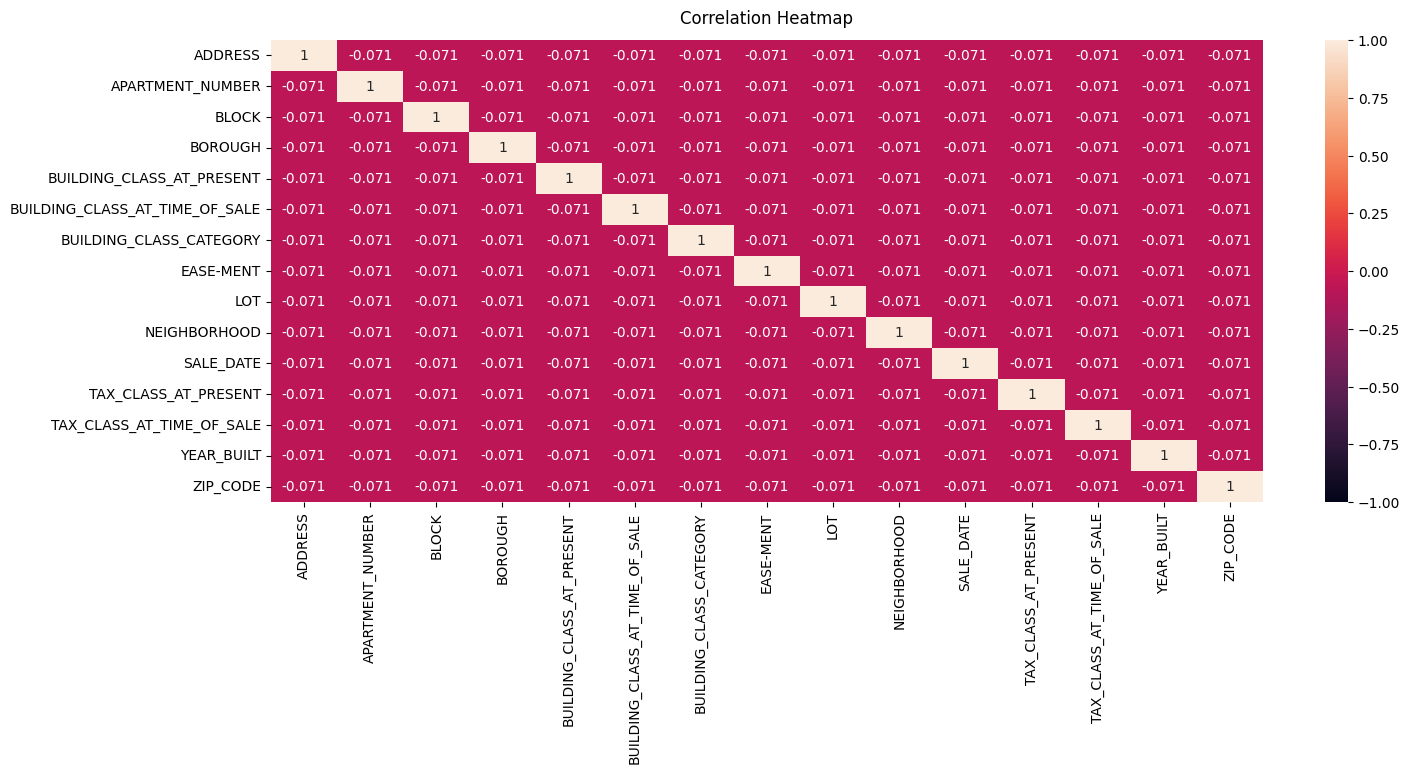

In [48]:

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

In [259]:
df.head()

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,NaN,13CONDOS-ELEVATORAPARTMENTS,NaN,738,1306,NaN,345WEST14THSTREET,10014,NaN,NaN,NaN,NaN,NaN,0,2,R4,0.053690,2013-05-20
1,NaN,13CONDOS-ELEVATORAPARTMENTS,NaN,738,1307,NaN,345WEST14THSTREET,10014,NaN,NaN,NaN,NaN,NaN,0,2,R4,0.040113,2013-05-16
2,NaN,13CONDOS-ELEVATORAPARTMENTS,NaN,738,1308,NaN,345WEST14THSTREET,10014,NaN,NaN,NaN,NaN,NaN,0,2,R4,0.025919,2013-05-23
3,NaN,13CONDOS-ELEVATORAPARTMENTS,NaN,738,1309,NaN,345WEST14THSTREET,10014,NaN,NaN,NaN,NaN,NaN,0,2,R4,0.033325,2013-05-15
4,NaN,13CONDOS-ELEVATORAPARTMENTS,NaN,738,1310,NaN,345WEST14THSTREET,10014,NaN,NaN,NaN,NaN,NaN,0,2,R4,0.039989,2013-05-13
